# pct.py

In [107]:
import numpy as np
import time
from argparse import Namespace


## Variables: u = [t, pos, vel, ang, omg]
# [2D]: u = [t, (x,y), (vx,vy), omega, theta]
# [3D]: u = [t, (x,y,z), (vx,vy,vz), (e1,e2,e3,e0), (w1,w2,w3)]

def time_(u):
    return u[0] if u.ndim == 1 else u[:,0]

def pos_(u):
    if u.ndim == 1:
        return u[1:3] if u.size == 7 else u[1:4]
    else:
        return u[:,1:3] if u.shape[-1] == 7 else u[:,1:4]

def vel_(u):
    if u.ndim == 1:
        return u[3:5] if u.size == 7 else u[4:7]
    else:
        return u[:,3:5] if u.shape[-1] == 7 else u[:,4:7]

def ang_(u):
    if u.ndim == 1:
        return u[5] if u.size == 7 else u[7:11]
    else:
        return u[:,5] if u.shape[-1] == 7 else u[:,7:11]

def omg_(u): 
    if u.ndim == 1:
        return u[6] if u.size == 7 else u[11:]
    else: 
        return u[:,6] if u.shape[-1] == 7 else u[:,11:]


## Material properties and simulation conditions

params = {'a': 1.0,         # semi-minor axis of particle
          'b': 1.0,         # semi-minor axis of particle
          'rho_p': 1.0,     # density of particle
          'rho_f': 1.0,     # density of fluid
          'dt': 1.0,        # calculation time step
          'eps_p': 1.0,     # permitivity of particle
          'eps_f': 1.0,     # permitivity of fluid
          'sig_p': 1.0,     # conductivty of particle
          'sig_f': 1.0,     # conductivity of fluid
          'freq': 1e6,      # AC frequency of electric field
}
params = Namespace(**params)

def update(params, show=True):
    params.r  = params.b/params.a
    params.r2 = (params.b/params.a)**2
    params.vol  = (4/3)*np.pi*params.a**2*params.b
    params.mass = params.vol*params.rho_p
    params.inertia_long  = 0.4*params.mass*params.a**2
    params.inertia_short = 0.2*params.mass*(params.a**2 + params.b**2)

    r, r2 = params.r, params.r2

    # DEP - Clausius-Mosostti factors
    depol_long  = 1/(1 + 1.6*r + 0.4*r**2)
    depol_short = (1 - depol_long)/2.
    eps_p = params.eps_p - 1J*params.sig_p/np.pi/params.freq/2.
    eps_f = params.eps_f - 1J*params.sig_f/np.pi/params.freq/2.
    kcm_long  = (eps_p-eps_f)/((eps_p-eps_f)*depol_long  + eps_f)
    kcm_short = (eps_p-eps_f)/((eps_p-eps_f)*depol_short + eps_f)

    params.kcm_long  = kcm_long.real
    params.kcm_short = kcm_short.real

    # Drag force coefficients (= 6 for a sphere)
    if r > 1:
        kdrag_long  =  8*(r2-1)/((2*r2-1)*log(r+sqrt(r2-1))/sqrt(r2-1) - r)
        kdrag_short = 16*(r2-1)/((2*r2-3)*log(r+sqrt(r2-1))/sqrt(r2-1) + r)
    else:
        kdrag_long = kdrag_short = 6

    params.kdrag_long  = kdrag_long
    params.kdrag_short = kdrag_short

    # Drag torque coeffients (= 8 for a sphere)
    if r > 1:
        a0 = -2/(r2-1) - r*log((r-sqrt(r2-1))/(r+sqrt(r2-1)))/(r2-1)**1.5
        b0 = r2/(r2-1) + r*log((r-sqrt(r2-1))/(r+sqrt(r2-1)))/(r2-1)**1.5/2
    else:
        a0 = b0 = 2/3.

    params.ktorq_long  = 32*r/(b0 + b0)/3.
    params.ktorq_short = 32*r/(r2*a0 + b0)/3.

    if show:
        print('\n' + '='*60)
        print("# Simulation parameters:\n" + '='*60)
        for key, value in sorted(params.__dict__.items()):
            print("{:13s} = {}".format(key, value))
        print('='*60)


## Functions

def rotation(ang):
    if len(ang) == 4:
        e1, e2, e3, e0 = ang
        return np.array([[1-2*(e2**2+e3**2), 2*(e1*e2+e3*e0), 2*(e1*e3-e2*e0)],
                        [2*(e2*e1-e3*e0), 1-2*(e3**2+e1**2), 2*(e2*e3+e1*e0)],
                        [2*(e3*e1+e2*e0), 2*(e3*e2-e1*e0), 1-2*(e1**2+e2**2)]]).T
    else: # 2D
        return np.array([[ np.cos(ang), np.sin(ang)],
                         [-np.sin(ang), np.cos(ang)]]).T

def euler2quat(psi, theta, phi):
    """ Euler angles in Z-X-Z rotation """
    e1 = np.cos((phi - psi)/2)*np.sin(theta/2)
    e2 = np.sin((phi - psi)/2)*np.sin(theta/2)
    e3 = np.sin((phi + psi)/2)*np.cos(theta/2)
    e0 = np.cos((phi + psi)/2)*np.cos(theta/2)
    return np.r_[e1, e2, e3, e0]

def jacobian(f, pos, h=1e-7):
    if len(pos) == 3:
        x, y, z = pos
        dfdx = (f(x+h, y, z) - f(x-h, y, z))/h/2.
        dfdy = (f(x, y+h, z) - f(x, y-h, z))/h/2.
        dfdz = (f(x, y, z+h) - f(x, y, z-h))/h/2.
        return np.array([dfdx, dfdy, dfdz]).T
    else: # 2D
        x, y = pos
        dfdx = (f(x+h, y) - f(x-h, y))/h/2.
        dfdy = (f(x, y+h) - f(x, y-h))/h/2.
        return np.array([dfdx, dfdy]).T

    
## Particle tracing solver [2D/3D]

def _onestep(f, u, dt, args=()):
    k1 = dt*f(u, 0., *args)
    k2 = dt*f(u + k1/2., dt/2., *args)
    k3 = dt*f(u + k2/2., dt/2., *args)
    k4 = dt*f(u + k3, dt, *args)
    return u + (k1 + 2*k2 + 2*k3 + k4)/6.

def trace2(eqns, u0, forces, torques, params, conditions, nmax=100000):
    print("\n>>> u0 =", u0)
    print(">>> Wait ...")

    u0 = np.concatenate([np.array(u0_).flatten() for u0_ in u0])
    sol = [u0]
    tstart = time.time()

    for i in range(nmax):
        u = _onestep(eqns, u0, params.dt, args=(forces, torques, params))
        if all(check(u) == True for check in conditions):
            sol.append(u)
            u0 = u
        else: break

    template = ">>> Calculation time: {:.2f} [s] /w {:d} [steps]"
    print(template.format(time.time() - tstart, i+1))
    return np.array(sol)

def trace(eqns, u0, forces, torques, params, conditions, nmax=100000):
    print("\n>>> u0 =", u0)
    print(">>> Wait ...")

    u0 = np.concatenate([np.array(u0_).flatten() for u0_ in u0])
    sol = np.empty((nmax, u0.size))
    sol[0] = u0
    tstart = time.time()

    for i in range(nmax-1):
        u = _onestep(eqns, u0, params.dt, args=(forces, torques, params))
        if all(check(u) == True for check in conditions):
            sol[i+1] = u
            u0 = u
        else: break

    template = ">>> Calculation time: {:.2f} [s] /w {:d} [steps]"
    print(template.format(time.time() - tstart, i+1))
    return np.array(sol[:i+2])



## Reference electric field

from scipy.special import ellipe, legendre
from scipy.interpolate import interp2d

def potential(x, y, vol, d1, d2, nmax=50):
    c, d = np.pi*d1/(d1+d2), 2*np.pi/(d1+d2)
    sum_phi, sum_an = 0, 0

    for n in range(1, nmax+1):
        ln, an = n-0.5, legendre(n-1)(np.cos(c))/ellipe(np.cos(c/2.))
        sum_phi += an*np.cos(ln*x*d)*np.exp(-ln*y*1E6)/ln
        sum_an += an/ln

    return vol*sum_phi/np.abs(sum_an)

x = np.linspace(-4, 14, 1001)*1e-6
y = np.linspace(0, 8, 501)*1e-6
gridx, gridy = np.meshgrid(x, y)

grid_phi = potential(gridx, gridy, vol=10, d1=8e-6, d2=2e-6)
grid_Ey, grid_Ex = np.gradient(-grid_phi, y, x)
grid_dyEx, grid_dxEx = np.gradient(grid_Ex, y, x)
grid_dyEy, grid_dxEy = np.gradient(grid_Ey, y, x)

func_Ex = interp2d(x, y, grid_Ex)
func_Ey = interp2d(x, y, grid_Ey)

grid_E2 = grid_Ex**2 + grid_Ey**2
grid_dyE2, grid_dxE2 = np.gradient(grid_E2, y, x)

func_dxE2 = interp2d(x, y, grid_dxE2)
func_dyE2 = interp2d(x, y, grid_dyE2)

# pct3d.py

In [108]:
import numpy as np
import matplotlib.pyplot as plt

# import pct


## 운동방정식/토크방정식 [3D]

def _total(funcs, u, params):
    return np.array([func(u, params) for func in funcs]).sum(axis=0)

def eqns3d(u, t, forces, torques, params):
    total_force = _total(forces, u, params) if len(forces) else np.zeros(3)
    total_torque = _total(torques, u, params) if len(torques) else np.zeros(3)
    
    I11 = params.inertia_long
    I22 = I33 = params.inertia_short
    I, I_inv = np.diag([I11, I22, I33]), np.diag([1/I11, 1/I22, 1/I33])
    e1, e2, e3, e0 = ang_(u)
    mat = np.array([[e0,-e3,e2], [e3,e0,-e1], [-e2,e1,e0], [-e1,-e2,-e3]])

    d_time = 1.0
    d_pos = vel_(u)
    d_vel = total_force/params.mass
    d_ang = mat.dot(omg_(u))/2.
    d_omg = I_inv.dot(total_torque - np.cross(omg_(u), I.dot(omg_(u))))
    return np.r_[d_time, d_pos, d_vel, d_ang, d_omg]

def trace3d(u0, forces, torques, params, conditions):
    return trace(eqns3d, u0, forces, torques, params, conditions)


## 중력 [3D]
from scipy.constants import g

def force_grav3d(u, params):
    return np.r_[0., -(params.rho_p - params.rho_f)*params.vol*g, 0.]


## Drag - 구형체(Sphere) [3D]

def force_drag3d_sph(u, params):
    x, y, z = pos_(u)
    return 6*np.pi*params.mu_f*params.a*(params.vf3d(x, y, z) - vel_(u))

def torque_drag3d_sph(u, params):
    R = rotation(ang_(u))
    L_xyz = jacobian(params.vf3d, pos_(u))
    L_123 = R.dot(L_xyz).dot(R.T)   # velocity gradient
    W_123 = (L_123 - L_123.T)/2     # rate of rotation

    w1, w2, w3 = omg_(u)
    t1 = W_123[2,1] - w1
    t2 = W_123[0,2] - w2
    t3 = W_123[1,0] - w3
    return 8*np.pi*params.mu_f*params.a**3*np.r_[t1, t2, t3]


## Drag - 타원체(Spheroid) [3D]

from numpy import log, sqrt

def force_drag3d(u, params):
    K11 = params.kdrag_long
    K22 = K33 = params.kdrag_short
    Kdrag = params.mu_f*np.pi*params.a*np.diag([K11, K22, K33])
    R, (x, y, z) = rotation(ang_(u)), pos_(u)
    return (R.T).dot(Kdrag).dot(R).dot(params.vf3d(x, y, z) - vel_(u))

def torque_drag3d(u, params):
    R = rotation(ang_(u))
    L_xyz = jacobian(params.vf3d, pos_(u))
    L_123 = R.dot(L_xyz).dot(R.T)   # velocity gradient
    D_123 = (L_123 + L_123.T)/2     # rate of deformation
    W_123 = (L_123 - L_123.T)/2     # rate of rotation

    K11 = params.ktorq_long
    K22 = K33 = params.ktorq_short
    Ktorq = params.mu_f*np.pi*params.a**3*np.diag([K11, K22, K33])
    r, (w1, w2, w3) = params.r, omg_(u)

    t1 = W_123[2,1] - w1
    t2 = (1 - r**2)*D_123[0,2]/2. + (1 + r**2)*(W_123[0,2] - w2)/2.
    t3 = (r**2 - 1)*D_123[1,0]/2. + (r**2 + 1)*(W_123[1,0] - w3)/2.
    return Ktorq.dot([t1, t2, t3])


## DEP - 구형체(Sphere) [3D]

def force_dep3d_sph(u, params):
    x, y, z = pos_(u)
    eps_p = params.eps_p - 1J*params.sig_p/np.pi/params.freq/2.
    eps_f = params.eps_f - 1J*params.sig_f/np.pi/params.freq/2.
    cmf = 3*(eps_p - eps_f)/(eps_p + 2*eps_f)
    grad_E2 = np.r_[func_dxE2(x, y)[0], func_dyE2(x, y)[0], 0.]
    return params.vol*params.eps_f*cmf.real*grad_E2/2.

def torque_dep3d_sph(u, params):
    return np.r_[0., 0., 0.]


## DEP - 타원체(Spheroid) [3D]

def force_dep3d(u, params):
    R, (x, y, z) = rotation(ang_(u)), pos_(u)
    Kcm = np.diag([params.kcm_long, params.kcm_short, params.kcm_short])
    E_123 = R.dot(params.elec3d(x, y, z))
    p_123 = params.vol*params.eps_f*Kcm.dot(E_123)
    return jacobian(params.elec3d, pos_(u)).dot(R.T).dot(p_123)

def torque_dep3d(u, params):
    R, (x, y, z) = rotation(ang_(u)), pos_(u)
    Kcm = np.diag([params.kcm_long, params.kcm_short, params.kcm_short])
    E_123 = R.dot(params.elec3d(x, y, z))
    p_123 = params.vol*params.eps_f*Kcm.dot(E_123)
    return np.cross(p_123, E_123)


## Post-pocessing

def plot_traj3d(ax, sol, length, nskip=100):
    sol = sol[::nskip]
    x, y, z = pos_(sol).T
    b = length/2.
    pt0 = pos_(sol)
    pt1 = np.array([pos_(s) + rotation(ang_(s)).dot([ b, 0, 0]) for s in sol])
    pt2 = np.array([pos_(s) + rotation(ang_(s)).dot([-b, 0, 0]) for s in sol])

    for (x0, y0, z0), (x1, y1, z1), (x2, y2, z2) in zip(pt0, pt1, pt2):
        ax.plot([x0, x1], [y0, y1], 'r-', lw=2)
        ax.plot([x0, x2], [y0, y2], 'g-', lw=2)

    ax.plot(x, y, 'k:', lw=2)
    return ax

# test dep

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import epsilon_0, micro

# import pct
# from pct import time_, pos_, vel_, omg_, ang_
# from pct3d import force_drag3d, force_dep3d, force_grav3d
# from pct3d import torque_drag3d, torque_dep3d


def electric_field3d(x, y, z):
    return np.r_[func_Ex(x, y)[0], func_Ey(x, y)[0], 0.]

def flow_velocity3d(x, y, z):
    return np.r_[0., 0., 0.]

pm_dep = params
pm_dep.elec3d = electric_field3d
pm_dep.vf3d = flow_velocity3d

pm_dep.eps_p = epsilon_0*9.5
pm_dep.eps_f = epsilon_0*8.3
pm_dep.sig_p = 600
pm_dep.sig_f = 2e-7
pm_dep.rho_p = 6150
pm_dep.rho_f = 967
pm_dep.mu_f = 1.1e-3
pm_dep.freq = 1e6
pm_dep.a = 0.5*micro/2.
pm_dep.b = 3.0*micro/2.
pm_dep.dt = 0.1e-6
# pm_dep.dt_skip = 1

update(pm_dep, show=False)

def check_time(u):   return True if time_(u) <= 0.001 else False
def check_height(u): return True if pos_(u)[1] > 0 else False

pos0 = 2*micro, 4*micro, 0.
ang0 = euler2quat(np.deg2rad(120), 0, 0.)
u0 = [0, pos0, (0, 0, 0), ang0, (0, 0, 0)]

# Trace ellipsoid particle
sol1 = trace3d(u0 = u0,
        forces  = [force_dep3d, force_drag3d, force_grav3d],
        torques = [torque_dep3d, torque_drag3d],
        params  = params,
        conditions = [check_time, check_height])

# Trace sphere particle
a, b = pm_dep.a, pm_dep.b
pm_dep.a = pm_dep.b = (a**2*b)**(1/3)
update(pm_dep, show=False)

sol2 = trace3d(u0 = u0,
        forces  = [force_dep3d, force_drag3d, force_grav3d],
        torques = [torque_dep3d, torque_drag3d],
        params  = params,
        conditions = [check_time, check_height])

# sol2 = trace3d(u0 = u0,
#             forces  = [force_dep3d_sph, force_drag3d_sph, force_grav3d],
#             torques = [torque_dep3d_sph, torque_drag3d_sph],
#             params  = params,
#             conditions = [check_time, check_height])

pm_dep.a, pm_dep.b = a, b
update(params, show=False)


>>> u0 = [0, (2e-06, 4e-06, 0.0), (0, 0, 0), array([ 0.       , -0.       ,  0.8660254,  0.5      ]), (0, 0, 0)]
>>> Wait ...
>>> Calculation time: 20.94 [s] /w 4058 [steps]

>>> u0 = [0, (2e-06, 4e-06, 0.0), (0, 0, 0), array([ 0.       , -0.       ,  0.8660254,  0.5      ]), (0, 0, 0)]
>>> Wait ...
>>> Calculation time: 9.94 [s] /w 4029 [steps]


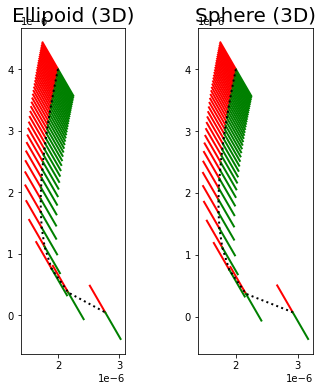

In [110]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,6))
ax1 = plot_traj3d(ax1, sol1, length=1*micro, nskip=100)
ax1.set_title("Ellipoid (3D)", fontsize=20)
ax2 = plot_traj3d(ax2, sol2, length=1*micro, nskip=100)
ax2.set_title("Sphere (3D)", fontsize=20)
ax1.set_aspect("equal")
ax2.set_aspect("equal")
plt.show()

# test flow

In [111]:
a = 1

In [112]:
u1 = sol1[0]
u1.size, u1.ndim

(14, 1)